# P3 Image Denoising

## Will Koehrsen wjk68

# Problem Explanation

In this notebook, we will the concepted of undirected graphs to remove noise from a binary image of 0s and 1s. The noisy image itself forms the observed variables, $y_i \in \{−1, +1\}$, and the hidden variables are the true image, that is the image without any noise, $x_i \in \{−1, +1\}$. 

We assume that the noisy image is created by randomly flipping a small percentage of the bits in the original image. We can then use an energy function and the concept of cliques between adjacent pixels to flip the values of the noisy image to reduce the total energy value. There should be a correlation both between neighboring pixels in the noisy image, $x_i$ and $x_j$ and between pixels in the noisy image $x_i$ and hidden, noise-free image $y_i$. The two types of cliques in the image are thus $\{x_i, x_j\}$ between neighboring pixels, and $\{x_i, y_i\}$ between pixels in the observed and hidden images. Further explanation of the energy function appears later in the notebook.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as imtool
%matplotlib inline

# Convolution for de-noising
from scipy.signal import convolve2d as conv2d

# Turn off axes by default in matplotlib
import matplotlib
matplotlib.rc('axes.spines', top=False, bottom=False, left=False, right=False);
matplotlib.rc('axes', facecolor=(1, 1, 1, 0), edgecolor=(1, 1, 1, 0))
matplotlib.rc(('xtick', 'ytick'), color=(1, 1, 1,0))

from IPython.core.pylabtools import figsize

# Original Image

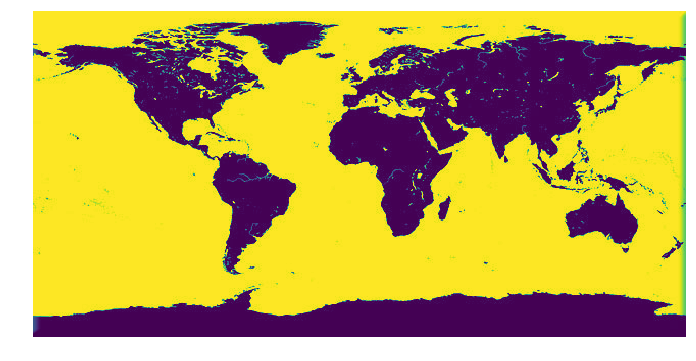

In [2]:
figsize(12, 6)
img = imtool.imread('images/world_binary.jpg')[:, :, 2]
plt.imshow(img); 

## Add Noise to Image

This function adds noise to the image (flips pixels) with `nratio` probability. For this example, I will flip 10% of the bits in the original image to create the noisy image.

In [3]:
def addnoise(imorg, nratio=0.1):
    imnsy = imorg.copy()
    # convert '0' to '-1'
    imnsy[imnsy == 0] = -1
    # create random value to indicate flipping pixels
    index = np.random.rand(*imnsy.shape)
    # flip pixels to generate noisy image
    imnsy[index < nratio] *= -1
    
    return imnsy

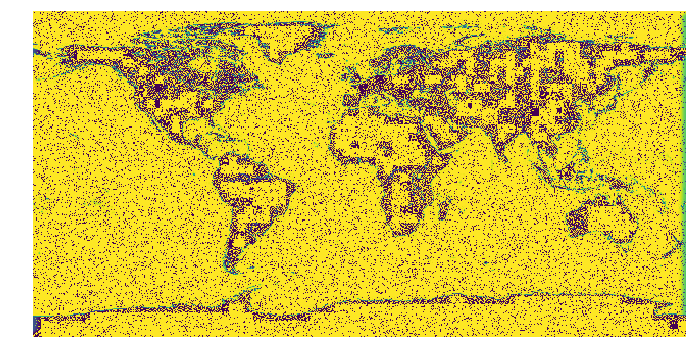

In [4]:
im_noisy = addnoise(img.astype('int16'))
plt.imshow(im_noisy.astype('uint8'));

In [5]:
def showimgs(*args, ncol=2):
    if not args:
        return
    # initialize figure with specific size
    plt.figure(figsize=(20, 14))
    # compose subplot index
    nrow = np.ceil(len(args) / ncol)
    subindex = nrow * 100 + ncol * 10
    # draw each image in subplot
    for i, img in enumerate(args):
        plt.subplot(subindex + i + 1)
        plt.imshow(img.astype('uint8'))

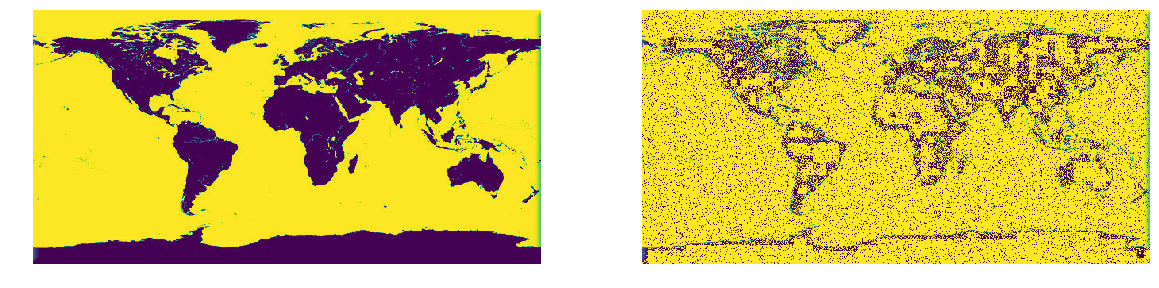

In [6]:
showimgs(img, im_noisy)

# Denoise image

The de-noising function takes 2 required arguments: a noisy image, and an energy function to minimize. The function first calculates the initial value of the energy function and the gradients of the energy function with respect to the noisy pixels values given the noisy image and a copy of the noisy image. It then flips all pixel values where the gradient is less than 0 and re-calculates the energy function and the gradients given the new image and the original noisy image. This process continues until flipping the pixels no longer decreases the value of the energy function. At this point, the energy function is considered to be minimized, and the function returns the current version of the image. This approach is not guaranteed to converge, and indeed, we will see it gets stuck in local minimum of the energy function. We can use different energy functions to improve the results, but the de-noising process still will not find the global minimum energy value.

In [7]:
def denoise(imnsy, efunc, showproc = False):
    # initialize recoverred image as noisy image
    imrec = imnsy.copy()
    # show noisy image
    if showproc:
        plt.imshow(imrec, cmap='gray')
        plt.title('Noisy Image')
        plt.show()
    # calculate energy function and its gradients
    E, dE = efunc(imrec, imnsy)
    # initialize temporal energy and iteration count
    Etmp, i = E + 1, 0
    # optimize energy function through iteration
    while Etmp > E:
        Etmp = E
        # update image by flipping all pixels, which could decrease energy function
        imrec[dE < 0] *= -1
        # calculate energy function with revised image
        [E, dE] = efunc(imrec, imnsy)
        # update iteration count
        i += 1
        # show revised image
        if showproc:
            plt.imshow(imrec, cmap='gray')
            plt.title('Recovered Image (Iter-%d)' % i)
            plt.show()
    # map '-1' to 0 in recovered image
    imrec[imrec == -1] = 0
    # return recovered image
    return imrec

## Default Energy Function

The default energy function has the form 

$$E(X,Y) = \alpha\sum\limits_{i} x_i - \beta \sum\limits_{i,j} x_i x_j - \eta \sum\limits_{i} x_i y_i $$

* $X$ is the pixel values of the hidden image and $Y$ is the pixel values of the observed (noisy) image. 

* $\alpha$ is a small constant multiplied by all the values in the hidden image that biases the model towards pixel values of one sign or the other. In effect $\alpha$ is a prior that represents our initial belief about the distribution of pixel values in the image. We add the term $\alpha * x_i$ for every pixel in the hidden, noise-free image. 

* $\beta$ is a positive constant that is multiplied by each clique $x_i x_j$ in the hidden image. This has the effect of increasing the energy function if adjacent pixels have different values.

* $\eta$ is also a small positive terms that is multiplied by each clique $x_i y_i$ representing the relationship between corresponding pixels in the hidden and observed image. Again, we want to increase the value of the energy function if these pixels differ in value. 

The energy function sums the bias over all pixels in the hidden image, sums the correlation between neighboring pixels over all cliques in the hidden images, and sums the correlation between pixels in the hidden and observed image for all cliques between the two images. The final value thus represents our assumptions that neighboring pixels tend to have the same value, and that corresponding pixels in the hidden and observed image should have the same value. 

We can express the joint probability of a given hidden and observed image using the energy function:

$$p(x, y) = \frac{1}{Z} \exp\{-E(x,y)\}$$

To de-noise an image, we can calculate the value of the energy function and the gradient of the energy function with repect to values in the observed image and flip pixel values in the observed image that have negative gradients. We then recalculate the value of the energy function after flipping the pixels to see if this decreases the value of the energy function. We continue this process until flipping pixel values no longer decreases the energy, at which point we say the image has been de-noised. However, this is not guaranteed to converge to the global minimum of the energy function and can get stuck in a local minimum value of the energy function. This mehtod is simply gradient descent. 


In [8]:
def defaultEnergyFunction(hidden, observation, alpha = 1, beta = 1, eta = 1):
    # create filter for beta term
    Tb = np.asarray([[0, 1.0, 0], [1.0, 0, 1.0], [0, 1.0, 0]])
    # calculate beta term in energy function for each pixel
    matB = np.zeros(hidden.shape)
    for i in range(len(hidden)):
        for j in range(len(hidden[0])):
            if i > 0:
                matB[i][j] += hidden[i-1][j]
            if j > 0:
                matB[i][j] += hidden[i][j-1]
            if i < len(hidden) - 1:
                matB[i][j] += hidden[i+1][j]
            if j < len(hidden[0]) - 1:
                matB[i][j] += hidden[i][j+1]
    # calculate energy map
    mapE = hidden * (alpha - beta * matB - eta * observation)
    # get mean of matrix as energy
    E = np.mean(mapE)
    # calculate energy difference map
    dE = -2 * mapE
    
    return E, dE

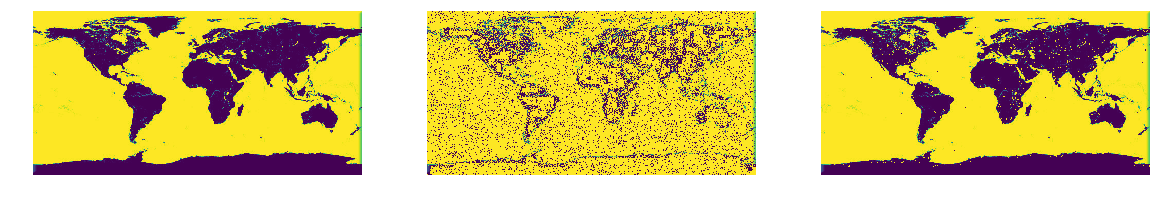

In [9]:
imrec = denoise(im_noisy, defaultEnergyFunction)
showimgs(img, im_noisy, imrec, ncol=3)

# Filtering

The $\beta$ term in the energy function acts as a filter. The $\beta$ term in the default energy function acts as a median filter of the form

![](class/imgdenoise/template-beta.png)

When we convolve this filter with an image, the result corresponds to the majority pixel value in the patch over which we perform the convolution. We can create an energy function using only the $\beta$ term to see the result of applying this median filter. 

In [10]:
def defaultEnergyFunction(hidden, observation, alpha = 1, beta = 1, eta = 1):
    # create filter for beta term
    Tb = np.asarray([[0, 1.0, 0], [1.0, 0, 1.0], [0, 1.0, 0]])
    # convolve hidden image with term B's filter
    matB = conv2d(hidden, Tb, 'same')
    # calculate energy map
    mapE = hidden * (alpha - beta * matB - eta * observation)
    # get mean of matrix as energy
    E = np.mean(mapE)
    # calculate energy difference map
    dE = -2 * mapE
    
    return E, dE

In [11]:
medFilter = lambda hidden, observation: defaultEnergyFunction(hidden, observation,
                                                              alpha=0, beta=1, eta=0)

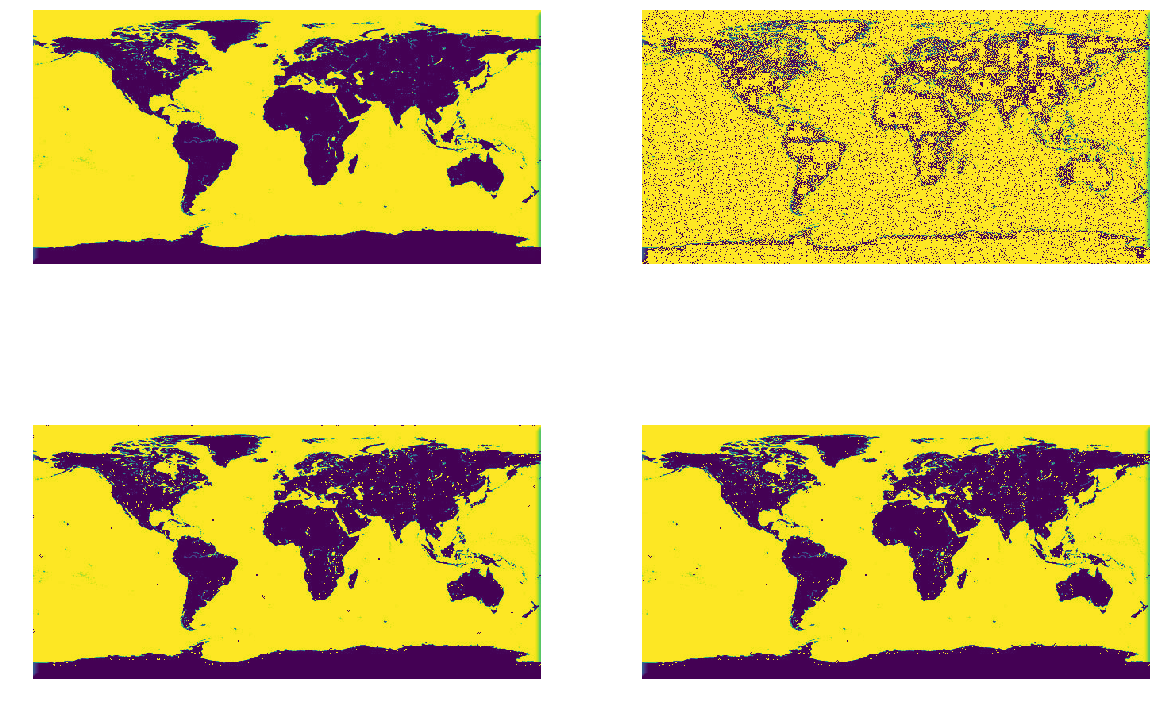

In [12]:
imrecMed = denoise(im_noisy, medFilter)
showimgs(img, im_noisy, imrec, imrecMed)

As can be seen, the median filter by itself does a decent job of decreasing the noise in the image, simply by taking the majority pixel vlaue in each patch of the image. For this implementation, we are assuming only that there is a relationship between neighboring pixels in the hidden image.

# Improvement of Default Energy Function

To improve the energy function, we can use different filter templates for $\beta$. 

Several different templates are shown below:

$T_{\alpha}$                            |  $T_{\gamma}$
----------------------------------------|----------------------------------------- 
<img src="class/imgdenoise/template-alpha.png" width="300">  |  <img src="class/imgdenoise/template-gamma.png" width="300">

$T_{\phi}$                            |  $T_{\sigma}$
--------------------------------------|-----------------------------------------
<img src="class/imgdenoise/template-phi.png" width="300">  |  <img src="class/imgdenoise/template-sigma.png" width="300">

These templates are all 5 x 5 because a 3 x 3 filter cannot remove noise that extends across more than two pixels. The new filters can be implemented in the same way as the original filter by defining the energy function with the filter convolved with the hidden image.

In [13]:
def extendEnergyFunction(hidden, observation, 
                         alpha=1, beta=1, gamma=1, phi=1, sigma=1, eta=1):
    # template alpha
    Ta = np.asarray([[[-1,-1,-1,-1,1],[-1,-1,-1,1,-1],[-1,-1,0,-1,-1],[-1,1,-1,-1,-1],[1,-1,-1,-1,-1]],
                     [[-1,-1,1,-1,-1],[-1,-1,1,-1,-1],[-1,-1,0,-1,-1],[-1,-1,1,-1,-1],[-1,-1,1,-1,-1]],
                     [[1,-1,-1,-1,-1],[-1,1,-1,-1,-1],[-1,-1,0,-1,-1],[-1,-1,-1,1,-1],[-1,-1,-1,-1,1]],
                     [[-1,-1,-1,-1,-1],[-1,-1,-1,-1,-1],[1,1,0,1,1],[-1,-1,-1,-1,-1],[-1,-1,-1,-1,-1]]])
    # template beta
    Tb = np.asarray([[0, 1, 0], [1, 0, 1], [0, 1, 0]])
    # template gamma
    Tr = np.asarray([[1,1,1,1,1],[1,0,0,0,1],[1,0,0,0,1],[1,0,0,0,1],[1,1,1,1,1]])
    # template phi
    Tp = np.asarray([[0,0,1,0,0],[0,0,1,0,0],[1,1,0,1,1],[0,0,1,0,0],[0,0,1,0,0]])
    # template sigma
    Ts = np.asarray([[[1,-1,-1,-1,-1],[1,0,-1,-1,-1],[1,1,0,-1,-1],[1,1,1,0,-1],[1,1,1,1,1]],
                     [[1,1,1,-1,-1],[1,1,0,-1,-1],[1,1,0,-1,-1],[1,1,0,-1,-1],[1,1,1,-1,-1]],
                     [[1,1,1,1,1],[1,1,1,0,-1],[1,1,0,-1,-1],[1,0,-1,-1,-1],[1,-1,-1,-1,-1]],
                     [[1,1,1,1,1],[1,1,1,1,1],[1,0,0,0,1],[-1,-1,-1,-1,-1],[-1,-1,-1,-1,-1]],
                     [[1,1,1,1,1],[-1,0,1,1,1],[-1,-1,0,1,1],[-1,-1,-1,0,1],[-1,-1,-1,-1,1]],
                     [[-1,-1,1,1,1],[-1,-1,0,1,1],[-1,-1,0,1,1],[-1,-1,0,1,1],[-1,-1,1,1,1]],
                     [[-1,-1,-1,-1,1],[-1,-1,-1,0,1],[-1,-1,0,1,1],[-1,0,1,1,1],[1,1,1,1,1]],
                     [[-1,-1,-1,-1,-1],[-1,-1,-1,-1,-1],[1,0,0,0,1],[1,1,1,1,1],[1,1,1,1,1]]])
    
    # generate parameter matrix alpha
    matA = np.empty(hidden.shape)
    for T in Ta:
        matA = np.maximum(matA, hidden * conv2d(hidden, T, 'same'))
    # generate parameter matrix beta
    matB = conv2d(hidden, Tb, 'same')
    # generate parameter matrix gamma
    matR = conv2d(hidden, Tr, 'same')
    # generate parameter matrix phi
    matP = conv2d(hidden, Tp, 'same')
    # generate parameter matrix sigma
    matS = np.empty(hidden.shape)
    for T in Ts:
        matS = np.maximum(matS, hidden * conv2d(hidden, T, 'same'))
        
    # calculate energy map
    mapE = -alpha*matA - sigma*matS - hidden*(beta*matB + gamma*matR + phi*matP + eta*observation)
    # get energy value as mean of map
    E = np.mean(mapE)
    # calculate energy difference map
    dE = -2 * mapE
    
    return E, dE

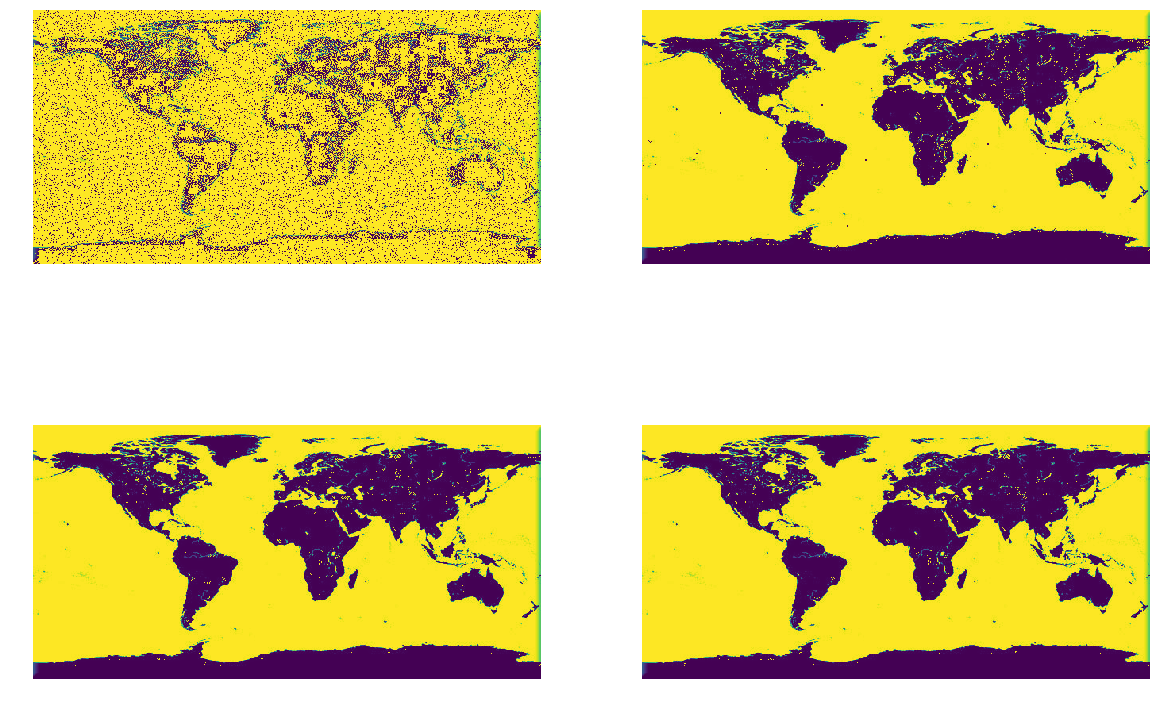

In [14]:
medFilterExt = lambda hidden, observation: extendEnergyFunction(hidden, observation, 
                                                                alpha=0, beta=1, gamma=0.1, 
                                                                phi=0, sigma=0, eta=0)

medFilterLarge = lambda hidden, observation: extendEnergyFunction(hidden, observation, 
                                                                  alpha=0, beta=0, gamma=0, 
                                                                  phi=1, sigma=0, eta=0)

# denoise image with new energy functions
imrecMedExt = denoise(im_noisy, medFilterExt)
imrecMedLag = denoise(im_noisy, medFilterLarge)

# compare result from different median filter
showimgs(im_noisy, imrecMed, imrecMedExt, imrecMedLag)

# Handling Edges

The final implementation in this notebook using filters that prevent edge corrosion. These should speed up optimization, but will not further improve the filtering results. 

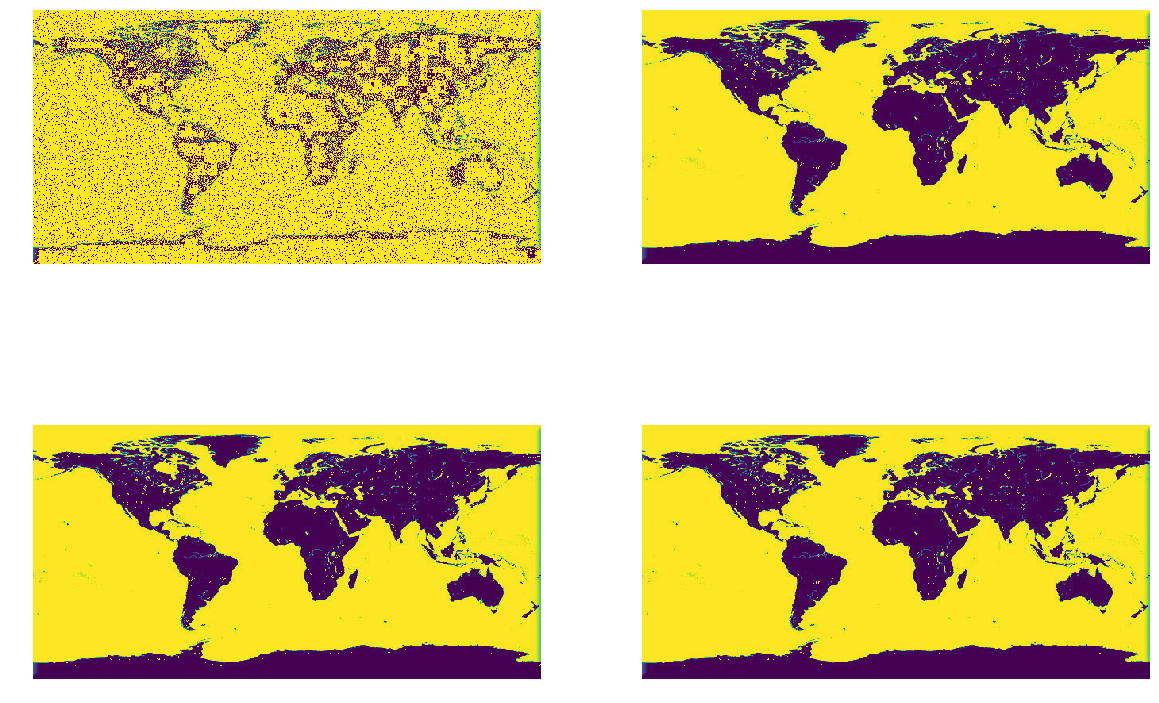

In [15]:
medFilterProtectA = lambda hidden, observation: extendEnergyFunction(hidden, observation, 
                                                                     alpha=0.1, beta=1, gamma=0.1, 
                                                                     phi=0, sigma=0, eta=0)

medFilterProtectS = lambda hidden, observation: extendEnergyFunction(hidden, observation, 
                                                                     alpha=0, beta=1, gamma=0.1, 
                                                                     phi=0, sigma=0.1, eta=0)

# denoise image with new energy functions
imrecMedProtectA = denoise(im_noisy, medFilterProtectA)
imrecMedProtectS = denoise(im_noisy, medFilterProtectS)

# compare result from different median filter
showimgs(im_noisy, imrecMedExt, imrecMedProtectA, imrecMedProtectS)

# Conclusions

In this notebook we saw how we could use a graphical model of an image to remove random noise from an image. The model works by assuming that cliques (adjacent pixels) in the hidden image should hve the same value, and that corresponding pixels in the hidden and observed images should have the same value. We also saw that we could add a term to bias the results toward one particular pixel value. The process works by calculating a loss (energy) as a function of the hidden and observed image of the form:

$$E(X,Y) = \alpha\sum\limits_{i} x_i - \beta \sum\limits_{i,j} x_i x_j - \eta \sum\limits_{i} x_i y_i $$

The process to de-noise an image requires using gradient descent to find the pixel values that minimize the energy function. Gradient descent is an iterative approach that calculates the value of the loss function and the gradient of the loss function with regards to the model parameters (in this case the hidden image) to find the model parameters that minimize the loss. One issue with gradient descent is it can get stuck in a local optimum. That is, it can find a value of hidden image that achieves a local minimum of the energy function but not a global minimum. There are ways to try and overcome this tendency, such as stochastic gradient descent and simulated annealing. 

Using the energy function, we can express the joint probability of a hidden and observed image:

$$p(x, y) = \frac{1}{Z} \exp\{-E(x,y)\}$$

where $Z$ is a normalization constant. The process of using gradient descent to minimize the energy function is therefore a process of finding the hidden image that maximizes the probability of the hidden and observed image. Furthermore, we saw how the $\beta$ term, which accounts for similarity between adjacent pixels in the hidden image, acts as a filter. We therefore can perform convolution of this filter over the hidden image rather than looping through every clique to speed up the optimization. 

This notebook looked at several methods for improving de-noising. First, we took the default energy function and made it faster using convolution to calculate the contribution to the energy function of adjacent pixels in the hidden image. Then, we looked at using different 5 x 5 filters that can remove noise on a larger scale. Finally, we use filters that attempted to speed up convergence by handling the edges although these did not improve the filtering result. Overall, the approach of assuming a graphical image model to remove noise from an image works quite well and further improvement to the gradient descent algorithm to minimize the energy function or trying different filters could yield better results. 

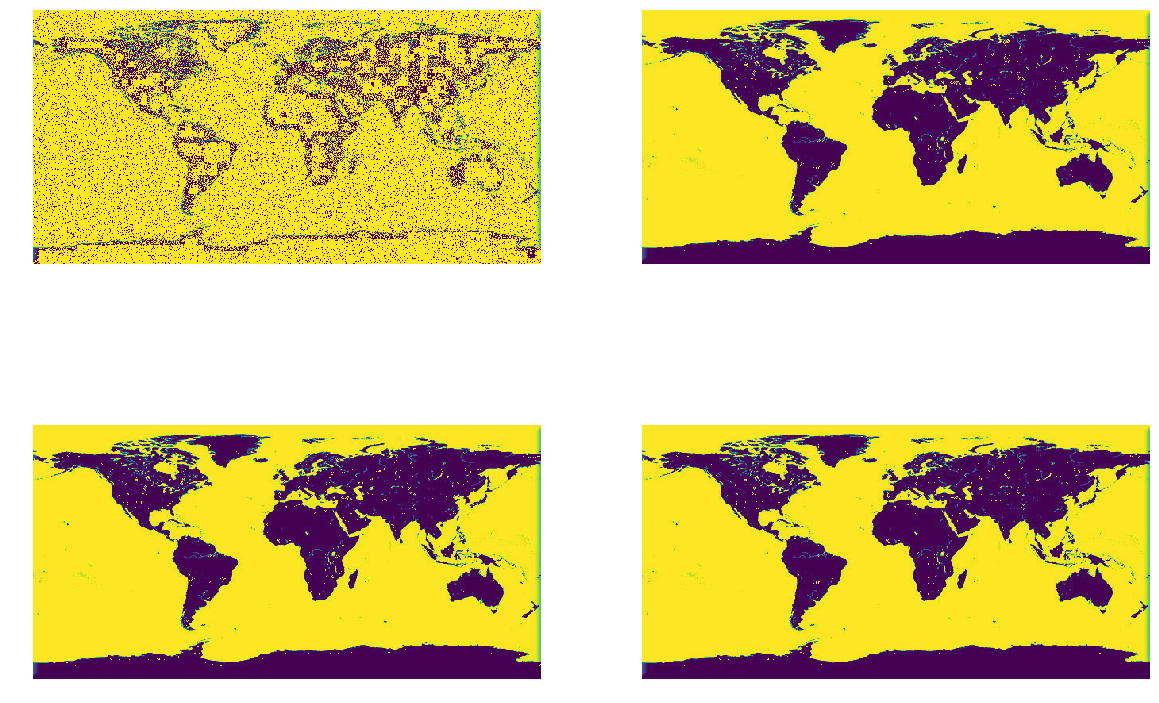

In [16]:
# denoise image with new energy functions
imrecMedProtectA = denoise(im_noisy, medFilterProtectA)
imrecMedProtectS = denoise(im_noisy, medFilterProtectS)

# compare result from different median filter
showimgs(im_noisy, imrecMedExt, imrecMedProtectA, imrecMedProtectS)